# **Chapter 9 추천 시스템**

### **[개념 정리]**

#### **05 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

##### **장르 속성을 이용한 영화 콘텐츠 기반 필터링**

콘텐츠 기반 필터링
> 사용자가 특정 영화를 감상하고, 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것

#### **06 아이템 기반 최근접 이웃 협업 필터링 실습**

### **[필사]**

#### **05 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

##### **데이터 로딩 및 가공**

In [7]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [9]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity',
                    'keywords', 'overview']]

In [11]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


In [13]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

In [15]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


##### **장르 콘텐츠 유사도 측정**

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0.0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


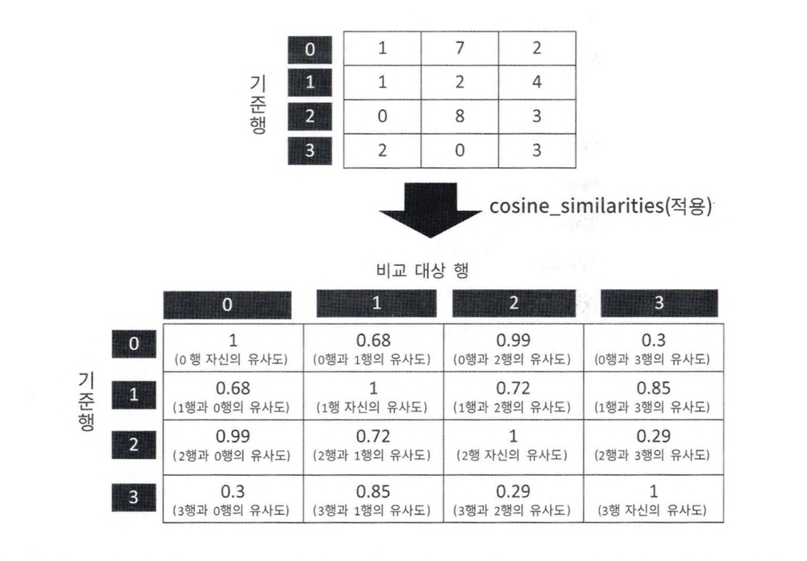

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


In [30]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


0번 레코드의 경우 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고, 그다음이 813번 레코드이며, 가장 유사도가 낮은 레코드는 2401 번 레코드라는 뜻

##### **장르 콘텐츠 필터링을 이용한 영화 추천**

장르 유사도에 따라 영화를 추천하는 함수 생성

In [40]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
    title_movie = df[df['title'] == title_name]

    # title_name을 가진 DataFrame의 index 객체를 ndarray로 반환하고
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]

    # 추출된 top_n index 출력. top_n index는 2차원 데이터임.
    # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)

    return df.iloc[similar_indexes]

find_sim_movie( ) 함수를 이용해 영화 ‘대부’와 장르별로 유사한 영화 10개를 추천

In [43]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


더 많은 후보군을 선정한 뒤에 영화의 평점에 따라 필터링해서 최종 추천하는 방식

In [46]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average',
                                                               ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


왜곡된 평점 데이터 존재

IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating) 방식 사용

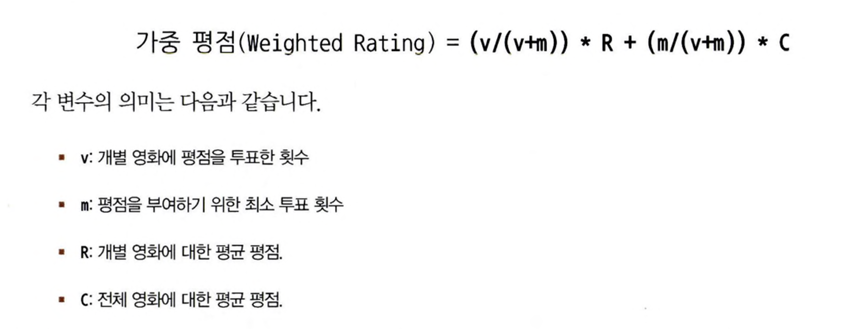

V는 movies_df의 ‘vote_counf 값이며, R 값은 ‘vote_average’ 값에 해당, C의 경우 전체 영화의 평균 평점이므로 movies_df['vote_average'].mean(), m의 경우는 투표 횟수에 따른 가중치를 직접 조절하는 역할

In [52]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


In [54]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ((v/(v+m))*R)+((m/(m+v))*C)

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [56]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [58]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title']==title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote',ascending = False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title','vote_average','weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


#### **06 아이템 기반 최근접 이웃 협업 필터링 실습**

In [65]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


In [67]:
ratings = ratings[['userId','movieId','rating']]
ratings_matrix = ratings.pivot_table('rating',index='userId',columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# title 칼럼을 얻기 위해 movies와 조인
ratings_movies = pd.merge(ratings, movies, on='movieId')

# columns = 'title'로 title 칼럼으로 피벗 수행
ratings_matrix = ratings_movies.pivot_table('rating',index='userId',columns='title')

# NaN값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### **영화 간 유사도 산출**

영화 간의 유사도는 코사인 유사도를 기반으로 하고 사이킷런의 cosine_similarity()를 이용해 측정

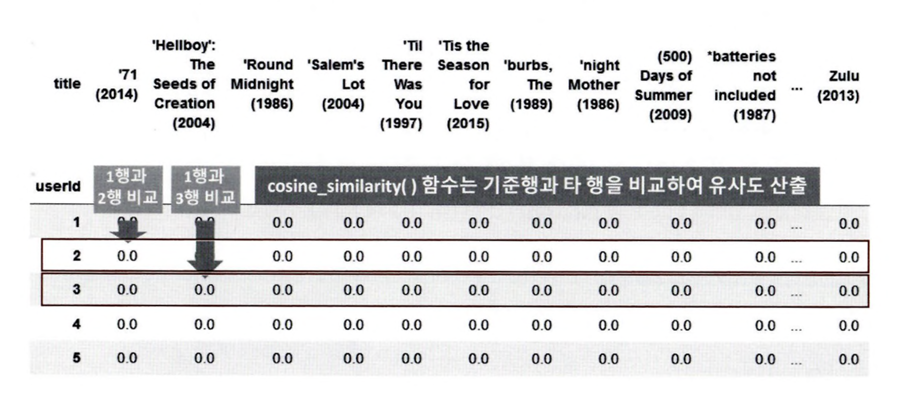

In [71]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                           columns = ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [78]:
item_sim_df['Godfather, The (1972)'].sort_values(ascending = False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

In [80]:
item_sim_df['Inception (2010)'].sort_values(ascending = False)[:6]

title
Inception (2010)                 1.000000
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

##### **아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천**

개인화된 영화추천의 가장 큰 특징은 개인이 아직 관람하지 않은 영화를 추천한다는 것
> 아직 관람하지 않은 영화에 대해서 아이템 유사도와 기존에 관람한 영화의 평점 데이터를 기반으로 해 새롭게 모든 영화의 예측 평점을 계산한 후 높은 예측 평점을 가진 영화를 추천하는 방식

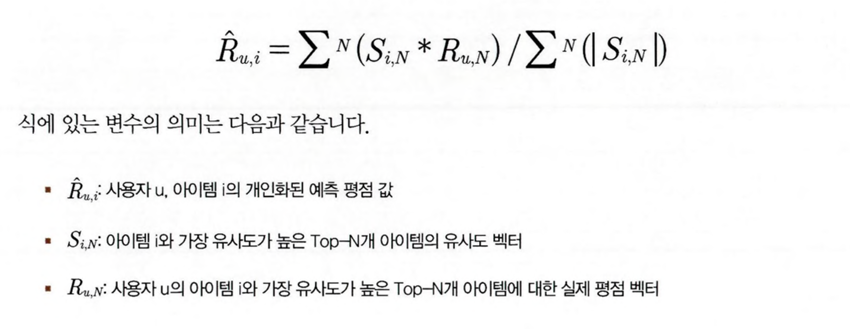

In [84]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr)/np.array([np.abs(item_sim_arr).sum(axis=1)])
  return ratings_pred

In [86]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data = ratings_pred, index = ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


In [88]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함.
def get_mse(pred, actual):
  # 평점이 있는 실제 영화만 추출
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE: 9.895354759094706


In [90]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
  # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
  pred = np.zeros(ratings_arr.shape)

  # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
  for col in range(ratings_arr.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
    top_n_items = [np.argsort(item_sim_arr[:,col])[:-n-1:-1]]
    # 개인화된 예측 평점을 계산
    for row in range(ratings_arr.shape[0]):
      pred[row, col] = item_sim_arr[col,:][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
      pred[row, col] /= np.sum(np.abs(item_sim_arr[col,:][top_n_items]))

  return pred

In [92]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)
print('아이템 기반 최근접 Top-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)

아이템 기반 최근접 Top-20 이웃 MSE:  3.695009387428144


In [93]:
user_rating_id = ratings_matrix.loc[9,:]
user_rating_id[user_rating_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64